In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [9]:
# Создание дневной температуры со случайными аномалиями
def generate_temperature_data(start_date, end_date, anomalies_prob=0.1):
    dates = pd.date_range(start=start_date, end=end_date)
    temperature = np.random.normal(25, 5, len(dates))  # Среднее 25°C, стандартное отклонение 5°C

    # Добавление аномалий
    anomalies = np.random.choice([True, False], size=len(dates), p=[anomalies_prob, 1 - anomalies_prob])
    temperature[anomalies] += np.random.normal(0, 15, np.sum(anomalies))  # Случайное изменение температуры

    return dates, temperature

In [ ]:
generate_temperature_data('2023-01-01','2023-12-31')

In [11]:
# График температуры
def plot_temperature_data(dates, temperature, title):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, temperature, color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
# Создание и сохранение наборов данных
def create_and_save_datasets(num_datasets, data_dir, start_date, end_date, anomalies_prob=0.1):
    os.makedirs(data_dir, exist_ok=True)
    for i in range(num_datasets):
        dates, temperature = generate_temperature_data(start_date, end_date, anomalies_prob)
        title = f'Dataset {i+1}'
        plot_temperature_data(dates, temperature, title)
        np.savetxt(os.path.join(data_dir, f'dataset_{i+1}.csv'), np.vstack((dates.astype(str), temperature)).T, delimiter=',', fmt='%s', header='Date,Temperature', comments='')

In [25]:
# Параметры
start_date = '2023-01-01'
end_date = '2023-12-31'
num_train_datasets = 5
num_test_datasets = 2
train_data_dir = 'train'
test_data_dir = 'test'

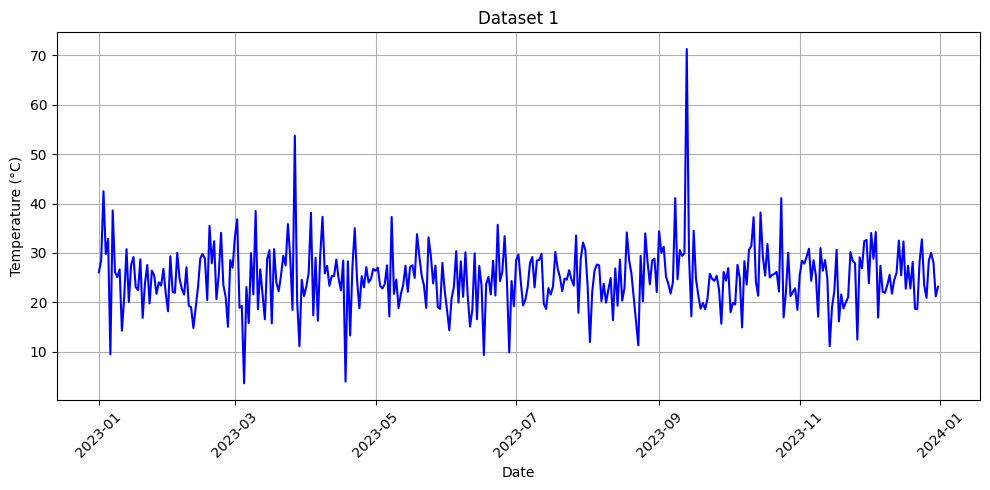

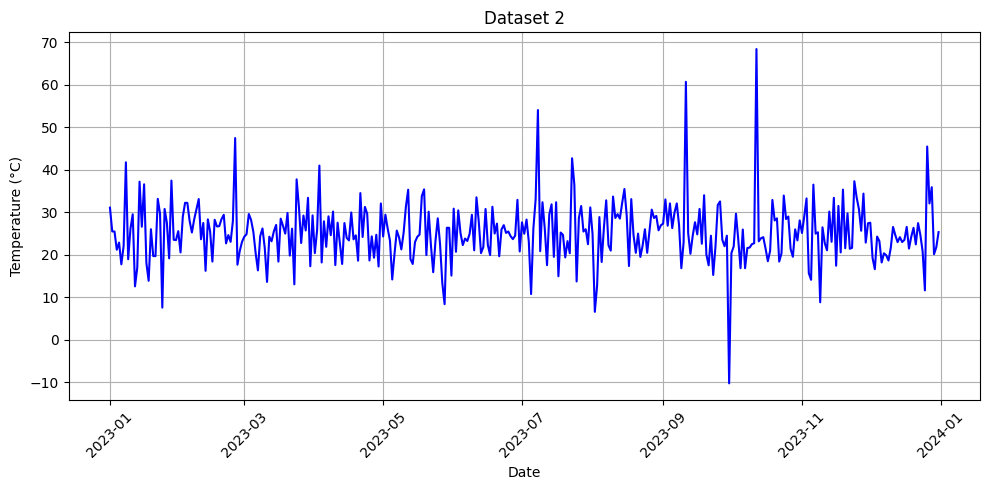

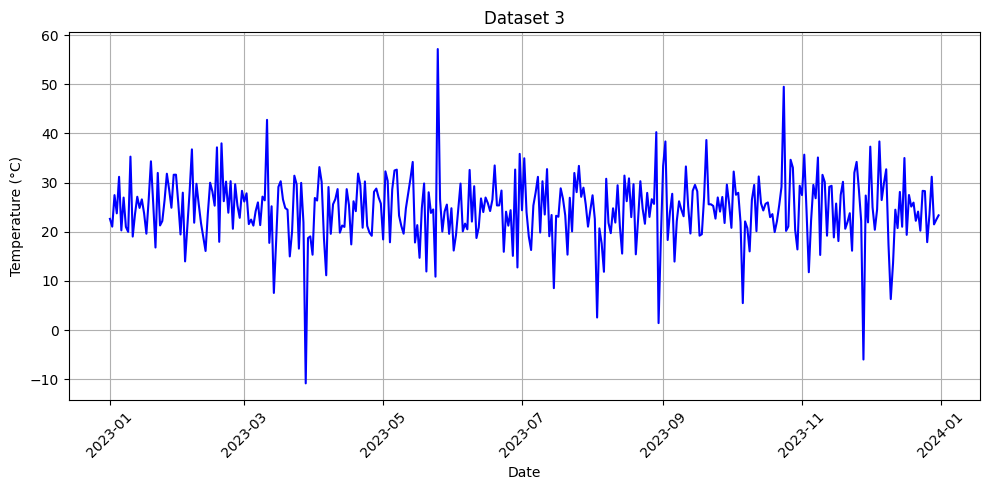

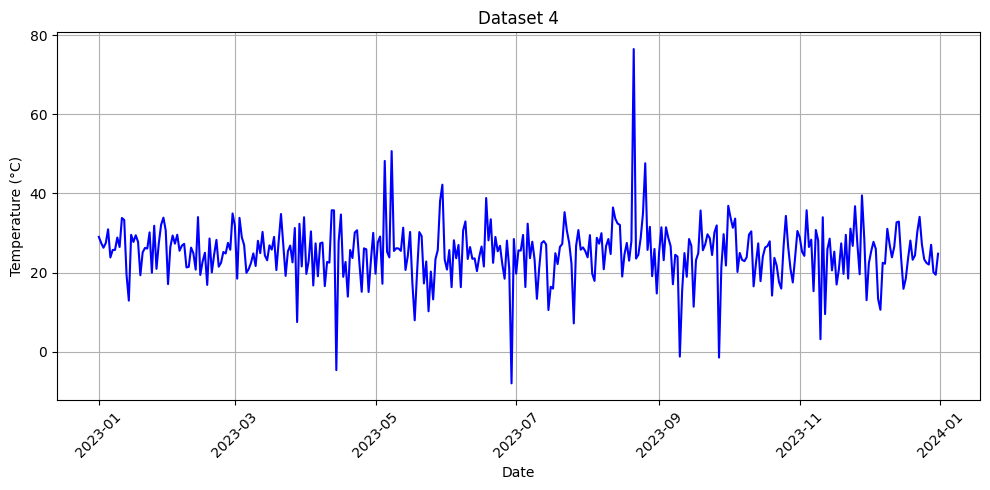

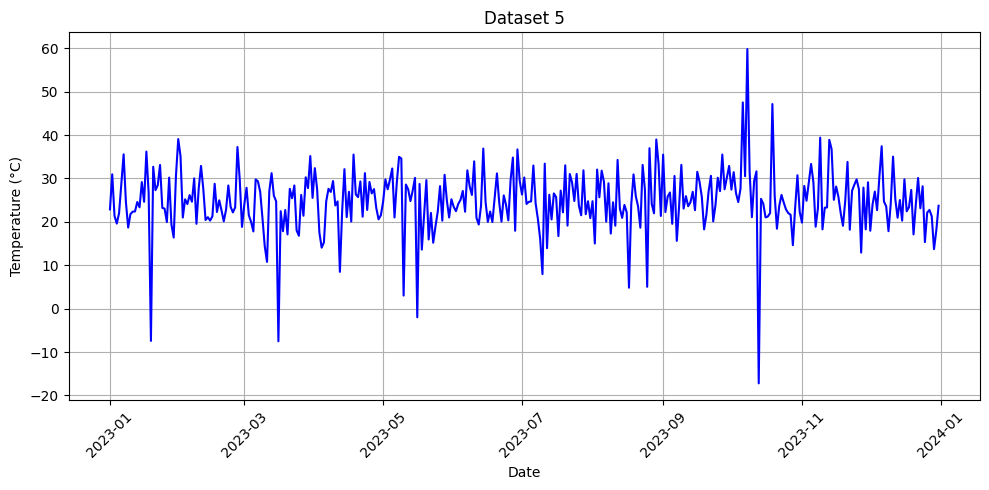

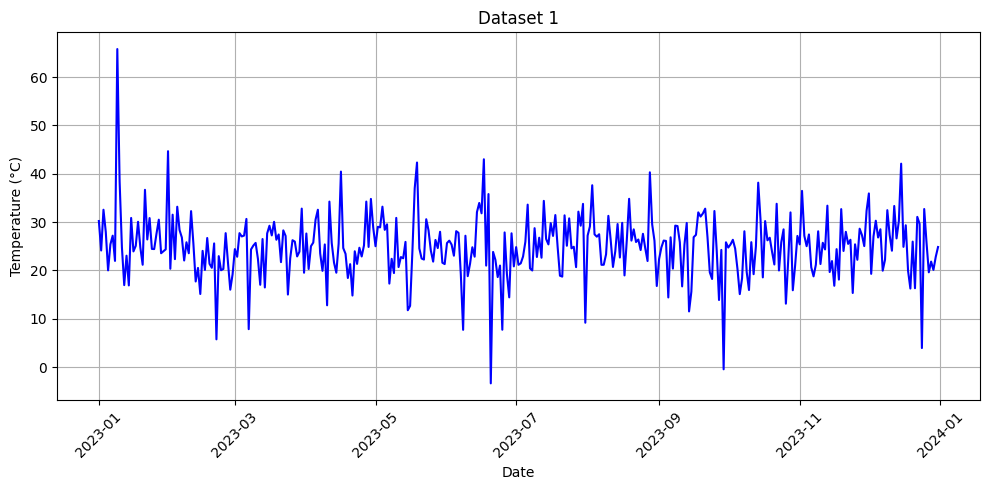

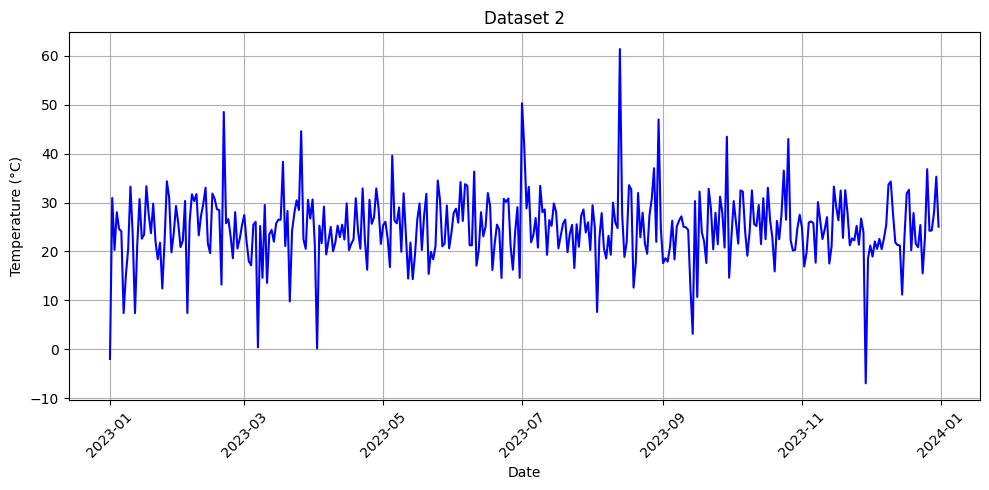

In [26]:
# Создание и сохранение наборов данных для тренировки и тестирования
create_and_save_datasets(num_train_datasets, train_data_dir, start_date, end_date)
create_and_save_datasets(num_test_datasets, test_data_dir, start_date, end_date)

In [58]:
# Функция для загрузки данных из CSV-файла
def load_data(data_dir):
    data = []
    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            data.append(df)
    return data

In [ ]:
data = load_data("train")
data

In [41]:
# Функция для предобработки данных с помощью StandardScaler
def preprocess_data(data):
    scaler = StandardScaler()
    preprocessed_data = []
    for df in data:
        # Преобразование признаков (температуры)
        temperature = df['Temperature'].values.reshape(-1, 1)
        temperature_scaled = scaler.fit_transform(temperature)

        # Обновление DataFrame с масштабированными значениями температуры
        df['Temperature'] = temperature_scaled.flatten()
        preprocessed_data.append(df)
    return preprocessed_data

In [ ]:
preprocess_data(data)

In [48]:
# Функция для сохранения предобработанных данных в CSV-файлы
def save_preprocessed_data(preprocessed_data, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, df in enumerate(preprocessed_data):
        file_path = os.path.join(output_dir, f'preprocessed_dataset_{i+1}.csv')
        df.to_csv(file_path, index=False)

In [49]:
# Пути к данным
train_data_dir = 'train'
test_data_dir = 'test'
output_train_data_dir = 'preprocessed_train'
output_test_data_dir = 'preprocessed_test'


In [50]:
# Загрузка данных
train_data = load_data(train_data_dir)
test_data = load_data(test_data_dir)

In [51]:
# Предобработка данных
preprocessed_train_data = preprocess_data(train_data)
preprocessed_test_data = preprocess_data(test_data)

In [53]:
# Сохранение предобработанных данных
save_preprocessed_data(preprocessed_train_data, output_train_data_dir)
save_preprocessed_data(preprocessed_test_data, output_test_data_dir)

In [57]:
def load_data(data_dir):
    data = []
    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            data.append(df)
    return data

In [97]:
def preprocess_data(data):
    for df in data:
        # Преобразуем дату в числовой формат (например, количество дней с начала года)
        df['Date'] = pd.to_datetime(df['Date'])
        df['Date'] = (df['Date'] - df['Date'].min()).dt.days
    return data

In [95]:
def train_model(train_data):
    X_train = np.array([])
    y_train = np.array([])
    for df in train_data:
        X_train = np.append(X_train, df['Date'].values)  # Используем дату в качестве признака
        y_train = np.append(y_train, df['Temperature'].values)

    X_train = X_train.reshape(-1, 1)  # Преобразуем в двумерный массив
    y_train = y_train.reshape(-1, 1)

    # Создаем и обучаем модель случайного леса
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train.ravel())
    return model

In [69]:
def save_model(model, model_path):
    joblib.dump(model, model_path)

In [98]:
def main(train_data_dir, model_output_path):
    # Загрузка данных
    train_data = load_data(train_data_dir)

    # Предобработка данных
    train_data = preprocess_data(train_data)

    # Обучение модели
    model = train_model(train_data)

    # Сохранение модели
    save_model(model, model_output_path)
    print("Модель успешно обучена и сохранена.")

In [103]:
# Обучаем данные
if __name__ == "__main__":
    train_data_dir = "preprocessed_train"
    model_output_path = "trained_model.pkl"
    main(train_data_dir, model_output_path)

Модель успешно обучена и сохранена.


In [105]:
def load_data(data_dir):
    data = []
    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            data.append(df)
    return data

In [106]:
def load_model(model_path):
    return joblib.load(model_path)

In [107]:
def test_model(test_data, model):
    predictions = []
    actual_values = []
    for df in test_data:
        X_test = df['Date'].values.reshape(-1, 1)  # Используем дату в качестве признака
        y_test = df['Temperature'].values

        # Прогнозирование температуры
        y_pred = model.predict(X_test)

        # Сохранение предсказанных и фактических значений
        predictions.append(y_pred)
        actual_values.append(y_test)

    return predictions, actual_values

In [108]:
def evaluate(predictions, actual_values):
    mse_scores = []
    for pred, actual in zip(predictions, actual_values):
        mse = mean_squared_error(actual, pred)
        mse_scores.append(mse)

    return mse_scores

In [112]:
def main(test_data_dir, model_path):
    # Загрузка данных
    test_data = load_data(test_data_dir)

    # Предобработка данных
    test_data = preprocess_data(test_data)

    # Загрузка модели
    model = load_model(model_path)

    # Тестирование модели
    predictions, actual_values = test_model(test_data, model)

    # Оценка результатов
    mse_scores = evaluate(predictions, actual_values)
    for i, mse in enumerate(mse_scores):
        print(f"Dataset {i+1} MSE: {mse}")

In [114]:
if __name__ == "__main__":
    test_data_dir = "preprocessed_test"
    model_path = "trained_model.pkl"
    main(test_data_dir, model_path)

Dataset 1 MSE: 1.230121834841185
Dataset 2 MSE: 1.2097464830513538
